In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
# 1. Carica il CSV e normalizza le date in formato YYYY-MM-DD
df = pd.read_csv('Data.csv')
df['Date'] = pd.to_datetime(df['Dates'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
df.set_index('Date', inplace=True)
df.drop(columns=['Dates'], inplace=True)

# 2. Identifica gli asset già in USD e le colonne FX
# Asset nativi in USD (quotati direttamente in USD)
usd_assets = ['Nasdaq', 'US_2y', 'US_10y', 'Copper', 'Wheat', 'Corn', 'Rice', 'Gold', 'Oil']
# Colonne FX presenti nel DataFrame
fx_columns = [c for c in df.columns if len(c) == 6 and c.isupper()]

# 3. Definisci gli asset locali da convertire: tutte le colonne escluse usd_assets e fx_columns
to_convert = [c for c in df.columns if c not in usd_assets + fx_columns]

# 4. Mappa di conversione local -> USD (colonna FX e invert flag)
# L'utente deve verificare che la mappa copra tutti i `to_convert`.
fx_map = {
    # Equity locali
    'Brazil_Equity':    ('USDBRL', True),   # USD/BRL -> dividere
    'Germany_Equity':   ('EURUSD', False),  # EUR/USD -> moltiplicare
    'Japan_Equity':     ('USDJPY', True),   # USD/JPY -> dividere
    'Australia_Equity': ('AUDUSD', False),  # AUD/USD -> moltiplicare
    'Spain_Equity':     ('EURUSD', False),  # EUR/USD -> moltiplicare
    # Tassi
    'Germany_2y':       ('EURUSD', False),
    'Germany_10y':      ('EURUSD', False),
    'Japan_10y':        ('USDJPY', True),
    'UK_10y':           ('GBPUSD', True),
    # Commodity/local FX
    'CADBRL':           ('USDBRL', True),
    'GBPMXN':           ('USDMXN', True),
    'SGDBRL':           ('USDBRL', True)
}

# 5. Funzione di conversione generica
def to_usd(series: pd.Series, fx_series: pd.Series, invert: bool = False) -> pd.Series:
    return series * (1/fx_series if invert else fx_series)

# 6. Costruisci DataFrame finale prices_usd
prices_usd = df[usd_assets].copy()
# Aggiungi direttamente le serie FX se vuoi monitorarle
# prices_usd[fx_columns] = df[fx_columns]

missing = []
for asset in to_convert:
    if asset not in fx_map:
        missing.append(asset)
        continue
    fx_col, invert = fx_map[asset]
    if fx_col not in df.columns:
        missing.append(asset)
        continue
    prices_usd[asset] = to_usd(df[asset], df[fx_col], invert=invert)

if missing:
    print("Attenzione: i seguenti asset non sono stati convertiti per mancanza di mapping o colonna FX:", missing)

# Remove negative values
#prices_usd = prices_usd[prices_usd>0]
prices_usd = prices_usd[(prices_usd > 0).all(axis=1)]

# 7. Output iniziale
print(prices_usd.columns)

Attenzione: i seguenti asset non sono stati convertiti per mancanza di mapping o colonna FX: ['Brazil_Equity', 'Australia_Equity', 'UK_10y']
Index(['Nasdaq', 'US_2y', 'US_10y', 'Copper', 'Wheat', 'Corn', 'Rice', 'Gold',
       'Oil', 'Germany_Equity', 'Japan_Equity', 'Spain_Equity', 'Germany_2y',
       'Germany_10y', 'Japan_10y'],
      dtype='object')


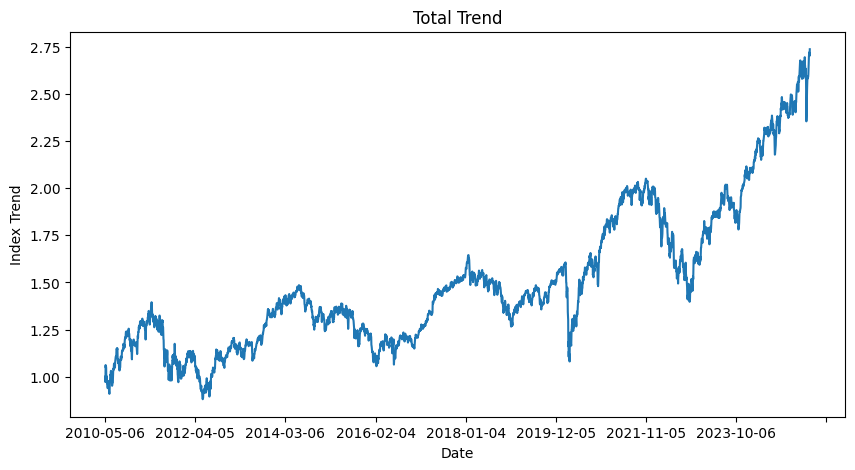

In [84]:
total_trend = prices_usd.sum(axis=1)
total_trend = total_trend/total_trend.iloc[0]
plt.figure(figsize = (10,5))
total_trend.plot()
plt.title('Total Trend')
plt.xlabel('Date')
plt.ylabel('Index Trend')
plt.show()
plt.close()

In [85]:
# Log Prices
log_prices = np.log(prices_usd)

# Percent returns
daily_returns = df.pct_change().dropna()

# Log returns
daily_log_returns = np.log(prices_usd).diff().dropna()

In [166]:
import numpy as np
import pandas as pd

# --- PARAMETERS ---
window         = 64        # look‐back length for correlation & z‐score
top_n          = 5          # number of pairs to trade each day
entry_z        = 2.0        # z‐score threshold to enter a trade
exit_z         = 0.0       # z‐score threshold to take profit
stop_z         = 3.0        # z‐score threshold to stop-loss
max_hold       = 32         # maximum holding period in calendar days
risk_per_trade = 0.01       # fraction of AUM risked per new trade
initial_AUM    = 100_000_000  # starting capital


# --- ASSUMED PRECOMPUTED DATA ---
# log_prices:         DataFrame of log prices (index = dates, cols = assets)
# daily_log_returns:  DataFrame of daily log-returns, same shape as log_prices

dates     = log_prices.index
AUM       = initial_AUM     # current account equity
NAV       = []              # list to store daily equity curve
positions = {}              # dict to track open trades

# --- MAIN BACKTEST LOOP ---
for t in range(window, len(dates)):
    today = dates[t]
    # define the look-back window of dates ending at 'today'
    past  = dates[t-window+1 : t+1]

    # 1) Compute the 100-day correlation matrix using returns in the window
    corr_t = daily_log_returns.loc[past].corr()

    # 2) Select the top_n pairs by absolute correlation
    #    - Create a boolean mask for the upper triangle (no duplicates)
    tri       = np.triu(np.ones(corr_t.shape), k=1).astype(bool)
    #    - Flatten to a Series of (asset_A, asset_B) -> |corr|
    corr_flat = corr_t.where(tri).stack().abs()
    #    - Pick the n largest correlations
    top_pairs = corr_flat.nlargest(top_n).index.tolist()
    #top_pairs = corr_flat.nsmallest(top_n).index.tolist()
    # 3) For each selected pair, estimate the spread and compute today's z-score
    spreads = {}  # will hold historical spread series for each pair
    zs      = {}  # will hold today's z-score for each pair
    for A, B in top_pairs:
        # 3a) Estimate cointegration slope β on all data up to today
        x = log_prices[B].loc[:today]
        y = log_prices[A].loc[:today]
        β = np.polyfit(x, y, 1)[0]    # slope of regression y ~ β x

        # 3b) Compute the spread series: s_t = y_t - β * x_t
        s = y - β * x

        # 3c) Compute rolling mean (μ) and std (σ) of the last 'window' spreads
        μ = s.iloc[-window:].mean()
        σ = s.iloc[-window:].std()

        # 3d) Today's z-score: (current spread - μ) / σ
        z = (s.iloc[-1] - μ) / σ

        spreads[(A, B)] = s
        zs[(A, B)]      = z

    # 4) ENTRY RULES: open new trades for pairs not already in 'positions'
    for pair, z in zs.items():
        if pair in positions:
            continue  # skip if already traded

        if z >  entry_z:
            direction = -1  # spread is high: short spread (sell A, buy B)
        elif z < -entry_z:
            direction = +1  # spread is low: long spread (buy A, sell B)
        else:
            continue  # no entry signal

        # 4a) Compute the price‐move delimiting entry_z → stop_z in points
        σ     = spreads[pair].iloc[-window:].std()
        Δz    = stop_z - entry_z
        Δs    = abs(Δz) * σ

        # 4b) Position size so that a move Δs equals risk_per_trade * AUM
        size = (risk_per_trade * AUM) / Δs

        # 4c) Record the new position
        positions[pair] = {
            'entry_date': today,
            'beta':       β,
            'dir':        direction,
            'size':       size,
            'entry_z':    z
        }

    # 5) EXIT RULES: check all open trades for take-profit, stop-loss, or timeout
    to_close = []
    for pair, pos in positions.items():
        z    = zs.get(pair, None)
        hold = (pd.to_datetime(today) - pd.to_datetime(pos['entry_date'])).days

        if z is None:
            # optionally skip if pair fell out of top_pairs
            continue

        # close if |z| < exit_z (profit), |z| > stop_z (loss), or hold ≥ max_hold
        if abs(z) < exit_z or abs(z) > stop_z or hold >= max_hold:
            # compute P&L: direction * (spread_today - spread_entry) * size
            s_today = spreads[pair].iloc[-1]
            s_entry = spreads[pair].loc[pos['entry_date']]
            pnl     = pos['dir'] * (s_today - s_entry) * pos['size']

            AUM += pnl
            to_close.append(pair)

    # remove closed positions from the book
    for pair in to_close:
        del positions[pair]

    # 6) Record today's equity and number of open trades
    NAV.append({
        'date':        today,
        'AUM':         AUM,
        'open_trades': len(positions)
    })

# After the loop, convert NAV list to a DataFrame
nav_df = pd.DataFrame(NAV).set_index('date')


# Daily NAV series
nav = nav_df['AUM']

# 1) Cumulative return (pct)
cum_ret = nav.iloc[-1] / nav.iloc[0] - 1

# 2) Daily returns
daily_ret = nav.pct_change().dropna()

# 3) Annualized volatility
ann_vol = daily_ret.std() * np.sqrt(252)

# 4) Annualized return
ann_ret = daily_ret.mean() * 252

# 5) Sharpe ratio (rf=0)
sharpe = ann_ret / ann_vol

# 6) Drawdowns
running_max    = nav.cummax()
drawdowns      = (nav - running_max) / running_max
max_drawdown   = drawdowns.min()

# 7) Calmar ratio (annualized return / |max drawdown|)
calmar = ann_ret / abs(max_drawdown)

# 8) Summary
metrics = {
    'Cumulative Return': cum_ret,
    'Annualized Return': ann_ret,
    'Annualized Volatility': ann_vol,
    'Sharpe Ratio': sharpe,
    'Max Drawdown': max_drawdown,
    'Calmar Ratio': calmar
}

for k, v in metrics.items():
    print(f"{k:25s}: {v:.4f}")




Cumulative Return        : 0.5040
Annualized Return        : 0.0613
Annualized Volatility    : 0.2929
Sharpe Ratio             : 0.2094
Max Drawdown             : -0.6268
Calmar Ratio             : 0.0979


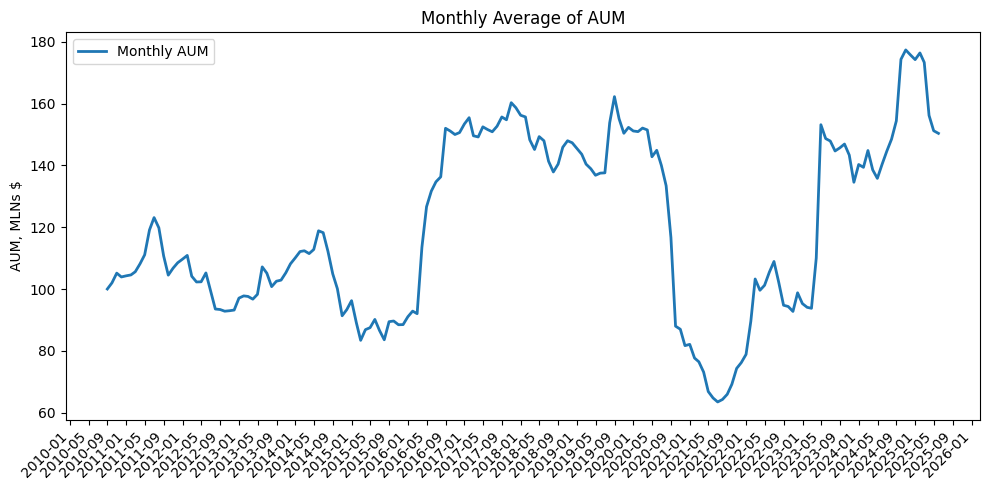

In [164]:
# 1) Assicurati di avere l’indice datetime
nav_df.index = pd.to_datetime(nav_df.index)

# 2) Resample month-end average
monthly = (nav_df['AUM']/1e6).resample('ME').mean()

# 3) Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(monthly.index, monthly.values, linewidth=2, label='Monthly AUM')  # linea continua

# 4) Tick ogni 2 mesi
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 5) Pulizia grafico
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Monthly Average of AUM')
ax.set_ylabel('AUM, MLNs $')
ax.legend()
plt.tight_layout()
plt.show()

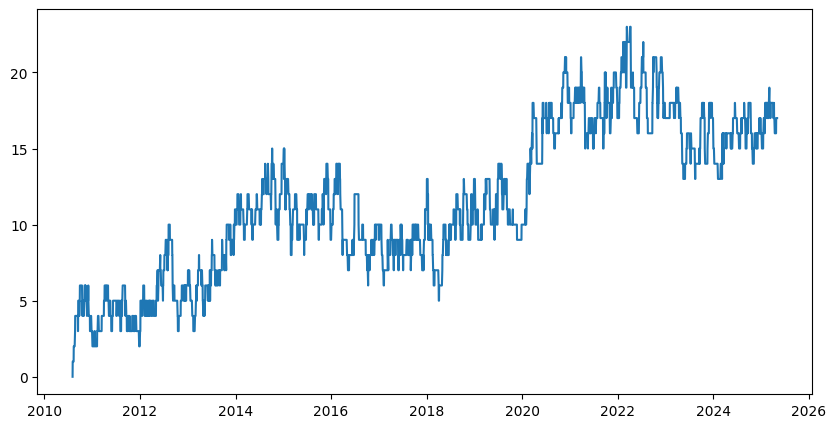

In [165]:
plt.figure(figsize = (10,5))
plt.plot(nav_df['open_trades'])
plt.show()